In [1]:
# einige Bibs
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model
from random import randint
#from scipy import stats

In [2]:
x_wert   = 0.2
z_wert   = 0.5

In [3]:
def make_forcast( days, products, maxsale, shuffle ):
    # try to generate random sales so that we have x,y,z cases
    sales = []
    sales = np.zeros((products,days), dtype=int)

    for pro in range( products ):
        # create empty array 
        timeline = []
        timeline = np.zeros(days)
        # sample how many values we should find
        # random limit
        #repl = randint( int(days *.8), days)
        repl = days

        #shuffle sale value per product    
        if shuffle:
            s_val = randint( int( maxsale * .05 ), maxsale)
        else:
            s_val = maxsale

        # 1 more X
        # 2 more Y
        # 3 more balance x,y
        # 4 more Z
        mode = randint( 1, 4)
        if mode == 1:
            low_lim = 0.85
        elif mode == 2:
            low_lim = 0.35
        elif mode == 3:
            low_lim = 0.45
        else:
            low_lim = 0.00001

        for i in range( repl ):
            #idx = randint(0, days-1)
            idx = i
            sales[pro][idx] += randint( int( s_val * low_lim ), s_val)
    return sales

In [4]:
# Datengenerierung - 365 Tagen je Produkt und maximale Verkaufszahl
mdays     = 12
mproducts = 19500
mmaxsale  = 7500
mshuffle  = True #different sale per product
sales = make_forcast( mdays, mproducts, mmaxsale, mshuffle )

In [5]:
def get_cla( koeffizient ):
    if mykoef <= x_wert:
        mycla = 'X'
    elif mykoef > z_wert:
        mycla = 'Z'
    else:
        mycla = 'Y'
    return mycla

In [6]:
def calc_koef( myval ):
    mystd = np.std( myval )
    myavg = np.mean( myval )
    mykoef = 0.0
    if mystd > 0 and myavg > 0:        
        mykoef = mystd /myavg
    return mykoef

In [7]:
# cnt error

def cnt_err():
    maxele = len( X_test )
    wrong = 0
    for idx in range(maxele):
        y_pred = clf.predict( [X_test[idx]] )
        #print( le.inverse_transform( y_pred ), le.inverse_transform( y_test[idx] ) )
        if y_pred  != y_test[idx]:
            wrong += 1
    err_rate = wrong * 100 / maxele
    
    return err_rate

def print_err():
    print( "Error rate:", cnt_err(), "%" )

In [8]:
# calculate the y-label classification

y = np.chararray(mproducts)
for pro in range(mproducts):
    mykoef = calc_koef( sales[pro] )
    #print( sales[pro], mykoef, get_cla( mykoef ))
    y[pro] = get_cla( mykoef )    

In [9]:
# see distribution of x, y, z
from collections import Counter
Counter( y )

Counter({b'Z': 3413, b'Y': 9095, b'X': 6992})

In [10]:
# prepare data for ML (splitt test & train)

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Y-Label codieren
le = preprocessing.LabelEncoder()
le.fit( y )
y_enc = le.transform(y)

# X-Label normieren
#X_scal = preprocessing.scale(sales)
scaler = StandardScaler() 
scaler.fit(sales)  
X = scaler.transform(sales) 
#X = sales

X_train, X_test, y_train, y_test = train_test_split( X, y_enc, test_size=0.4, random_state=0)

f:\ANA3\envs\w-gpu\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [11]:
# try SGD classifier

from sklearn.linear_model import SGDClassifier
#clf = SGDClassifier(loss="hinge", penalty="l2")
clf = SGDClassifier(loss="modified_huber", penalty="l2", max_iter=20, shuffle=True)
clf.fit(X_train, y_train)
print_err()

Error rate: 48.51282051282051 %


In [12]:
#look like best in class

# try MLP classifier
from sklearn.neural_network import MLPClassifier

alphas = np.logspace(-7, 0, 4) #start, dec, number of ranges
names = []
for i in alphas:
    names.append('alpha ' + str(i))
classifiers = []
for i in alphas:
    classifiers.append(MLPClassifier(alpha=i, random_state=1))

for name, clf in zip(names, classifiers):
#     clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
#                         hidden_layer_sizes=(5, 3), random_state=1, max_iter=20000)
    clf.fit(X_train, y_train)
    print( name )
    print_err()

    
# alpha 1e-07
# Error rate: 3.7948717948717947 %
# alpha 2.1544346900318867e-05
# Error rate: 3.7564102564102564 %
# alpha 0.004641588833612782
# Error rate: 3.8076923076923075 %
# alpha 1.0
# Error rate: 11.012820512820513 %

alpha 1e-07
Error rate: 3.948717948717949 %
alpha 2.1544346900318867e-05
Error rate: 3.8333333333333335 %
alpha 0.004641588833612782
Error rate: 3.948717948717949 %
alpha 1.0
Error rate: 9.423076923076923 %


In [13]:
# try Gradient Boost

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.07,
      max_depth=1, random_state=0).fit(X_train, y_train)

clf.score(X_test, y_test)       
print_err()

Error rate: 44.67948717948718 %


In [14]:
# try SVM - RBF, linear, poly

from sklearn import svm
#for mykernel in [ "rbf", "linear", "poly"]:
for mykernel in [ "rbf", "poly"]:
    print( mykernel )
    if mykernel == "poly":
        for mydegree in range (3,3):
            print( mydegree )
            clf = svm.SVC( kernel=mykernel, degree=mydegree)
            clf.fit(X_train, y_train) 
            print_err()
    else:
            clf = svm.SVC( kernel=mykernel)
            clf.fit(X_train, y_train)     
            print_err()

rbf
Error rate: 15.051282051282051 %
poly


In [15]:
# Gaussian Naive Bayes

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
print_err()

Error rate: 59.666666666666664 %


In [16]:
# try Kneighbors

from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(3, weights='distance')
clf.fit(X_train, y_train)
print_err()

Error rate: 24.96153846153846 %


In [17]:
# Try LSTM

from numpy import array
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dense, Dropout

# configure problem
length = mdays
output = 1
skill = np.empty((0, 5))
tmp_skill = skill
cnt = 0

epochen = 1 #set to min. 10 but takes time

for mems in ([40]):
    for epi in ([epochen]):
        # define model
        model = Sequential()
        #model.add(LSTM(mems, return_sequences=True, input_shape=(length, 1)))
        model.add(CuDNNLSTM(mems, return_sequences=True, input_shape=(length, 1)))
        #model.add(Dropout(0.2))
        model.add(CuDNNLSTM(mems))
        model.add(Dense(output))
        #model.compile(loss='mae', optimizer='adam')
        model.compile(loss='mean_squared_error', optimizer='RMSprop')
        print(model.summary())


        X_train2 = array(X_train).reshape(len(X_train), length, 1)
        y_train2 = array(y_train).reshape(len(y_train), output)

        X_test2 = array(X_test).reshape(len(X_test), length, 1)
        y_test2 = array(y_test).reshape(len(y_test), output)

        # fit model
        history = model.fit(X_train2, y_train2, batch_size=10, epochs=epi)

        # evaluate model
        loss = model.evaluate(X_test2, y_test2, verbose=0)
        print('MAE: %f' % loss)
        
        # prediction on new data
        yhat = model.predict(X_test2, verbose=0)
        
        # count the wrongs
        wrong = 0
        for myidx in range(len(yhat)):
            if int( yhat[myidx].round() ) != y_test[myidx]:
                wrong += 1

        tmp_skill = [mems, epi, loss, wrong * 100 / len(y_test)]
        skill = np.append(skill, [[tmp_skill]] )
        cnt += 1

print( "mem epi loss err")
print( np.reshape(skill, (cnt,-1) ) )


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 12, 40)            6880      
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 40)                13120     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 20,041
Trainable params: 20,041
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1
11700/11700 [==============================] - 19s 2ms/step - loss: 0.3211
MAE: 0.241183
mem epi loss err
[[40.          1.          0.24118302 23.79487179]]


In [18]:
# 2 stacked LSTM - loss=mae optimizier=adam
# mem epi loss err
# [[3.00000000e+00 5.00000000e+00 4.96083225e-01 4.89000000e+01]
#  [3.00000000e+00 1.50000000e+01 4.53991659e-01 4.49444444e+01]
#  [9.00000000e+00 5.00000000e+00 4.70264610e-01 4.53666667e+01]
#  [9.00000000e+00 1.50000000e+01 4.62792256e-01 4.53111111e+01]
#  [2.70000000e+01 5.00000000e+00 4.18998406e-01 4.14555556e+01]
#  [2.70000000e+01 1.50000000e+01 4.18741339e-01 4.16000000e+01]
#  [5.00000000e+01 5.00000000e+00 4.27951884e-01 4.17555556e+01]
#  [5.00000000e+01 1.50000000e+01 1.85453659e-01 1.56555556e+01]
#  [2.50000000e+02 5.00000000e+00 3.14345254e-01 2.72111111e+01]
#  [2.50000000e+02 1.50000000e+01 2.38970104e-01 2.15111111e+01]]

In [19]:
# 2 stacked CuDNNLST loss=mean_squared_error optimizer=RMSprop
#6000 products for training
# mem epi loss err
# [[50.         50.          0.07051103 10.24444444]]

#2000 products for training
# mem epi loss err
# [[5.00000000e+01 1.50000000e+02 9.35966077e-02 1.28333333e+01]]

#11700 products for training 
# mem epi loss err
# [[50.         80.          0.23339784 33.37179487]]

#11700 products for training 
# mem epi loss err
# [[150.          80.           0.22270456  31.75641026]]

In [20]:
# Trype to make forcast for products
# Datengenerierung - 365 Tagen je Produkt und maximale Verkaufszahl
mydays     = 350
myproducts = 500
mymaxsale  = 7500
myshuffle  = True #different sale per product
mysales = make_forcast( mydays, myproducts, mymaxsale, myshuffle )

In [21]:
# prepare data for ML (splitt test & train)

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# die letzten drei Werte in der Reihe entsprechen dem Forcast-Y-Label

#scaler = StandardScaler() 
#scaler.fit(mysales)
#myd_scale = scaler.fit_transform(mysales)

myd_scale = mysales

y = myd_scale[:,mydays-3:]
X = myd_scale[:,:mydays-3]

# X-Label normieren
# 
#   
# X = scaler.transform(X) 
#X = sales

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=0)


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import laplacian_kernel
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ( WhiteKernel, ExpSineSquared )
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
          1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
          1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                               length_scale_bounds=(0.1, 10.0),
                               periodicity_bounds=(1.0, 10.0)),
          ConstantKernel(0.1, (0.01, 10.0))
              * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.0, 10.0)) ** 2),
          1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                       nu=1.5)]

# kernels = [ ConstantKernel(0.1, (0.01, 10.0))
#                * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.0, 10.0)) ** 2) ]

kr_po = GridSearchCV(KernelRidge( gamma=0.01), n_jobs=-1,
                  param_grid={"alpha": [1e-2, 1e-1,0.5, 0.7],
                              "gamma": [1e-3, 1e-4], "kernel" : kernels})
                              #"kernel" : ['polynomial']})

In [23]:
kr_po.fit(X_train, y_train)
print(kr_po.best_params_)

{'alpha': 0.01, 'gamma': 0.001, 'kernel': 1**2 * RationalQuadratic(alpha=0.1, length_scale=1)}


In [24]:
# y_pred = kr_po.predict(X_test)
# for i in range(len(y_pred)):
#     mykoef = calc_koef( X_test[i] )
#     print( get_cla( mykoef )    )
#     print( X_test[i].mean() )
#     print( y_pred[i].mean() ) 
#     print( y_test[i].mean() )
#     print()

In [25]:
# X : array-like, shape = [n_samples, n_features]

# Training vectors, where n_samples is the number of samples and n_features is the number of features.

# y : array-like, shape = [n_samples]
    
    
myd_scale = mysales

y_tot = myd_scale[:,mydays-3:]
y = myd_scale[:,mydays-3:mydays-2]
X = myd_scale[:,:mydays-3]

# X-Label normieren
# 
#   
# X = scaler.transform(X) 
#X = sales

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=0)


In [26]:
# try Gradient Boost
from sklearn.ensemble import GradientBoostingRegressor

clf = GradientBoostingRegressor(n_estimators=500, learning_rate=0.07,
      max_depth=1, random_state=0, loss='ls' ).fit(X_train, y_train)



f:\ANA3\envs\w-gpu\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
# y_pred = clf.predict(X_test)
# for i in range(len(y_pred)):
#     mykoef = calc_koef( X_test[i] )
#     print( get_cla( mykoef )    )
#     print( X_test[i].mean() )
#     print( y_pred[i] ) 
#     print( y_test[i].mean() )
#     print()

In [28]:

# try Gradient Boost
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor( random_state=0, max_iter=5000, hidden_layer_sizes = (10,), activation = 'relu' ).fit(X_train, y_train)

f:\ANA3\envs\w-gpu\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
# y_pred = clf.predict(X_test)
# for i in range(len(y_pred)):
#     mykoef = calc_koef( X_test[i] )
#     print( get_cla( mykoef )    )
#     print( X_test[i].mean() )
#     print( y_pred[i] ) 
#     print( y_test[i].mean() )
#     print()

In [30]:
# shift forcast for half the element's and append prediction
X_new = X_test
for i in range( int( len(X_test[0]) / 2 ) ):    
    y_pred = clf.predict(X_new)
    X_new = X_new[:,1:]    
    tmp = np.append( X_new, [y_pred] )
    X_new = tmp.reshape(X_test.shape)        
    

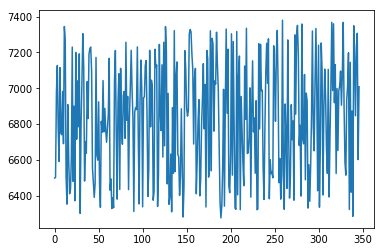

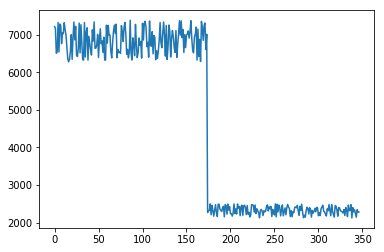

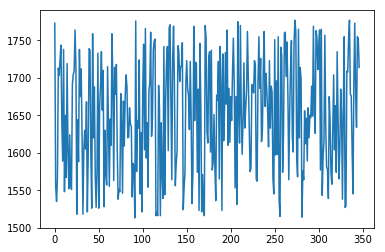

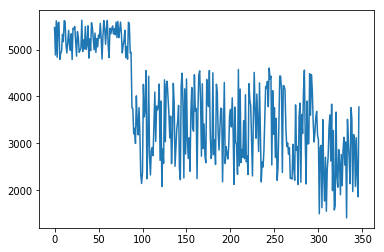

In [31]:
plt.plot(X_test[0])
plt.show()
plt.plot(X_new[0])
plt.show()
plt.plot(X_test[2])
plt.show()
plt.plot(X_new[2])

In [32]:
# try Ridge Regression
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1, solver="cholesky" ).fit(X_train, y_train)


In [33]:
# y_pred = clf.predict(X_test)
# for i in range(len(y_pred)):
#     mykoef = calc_koef( X_test[i] )
#     print( get_cla( mykoef )    )
#     print( X_test[i].mean() )    
#     print( y_test[i].mean() )
#     print( y_pred[i] ) 
#     print()

In [34]:
# try LASSO Regression
from sklearn.linear_model import Lasso
clf = Lasso(alpha=0.1).fit(X_train, y_train)


f:\ANA3\envs\w-gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [35]:
# y_pred = clf.predict(X_test)
# for i in range(len(y_pred)):
#     mykoef = calc_koef( X_test[i] )
#     print( get_cla( mykoef )    )
#     print( X_test[i].mean() )    
#     print( y_test[i].mean() )
#     print( y_pred[i] ) 
#     print()